# Introduction
Use an autoencoder to reduce the dimensionality of the dataset and sample from the latent space to generate new images.
Complete the code, run the cells and submit the notebook as a pdf 

In [18]:
# Libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from models import Autoencoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Change the device to a GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load the data  and initialize the model

In [19]:
# Data processing
faces = loadmat('./data/frey_rawface.mat')['ff'].T.reshape(-1, 28, 20)/255

# Model
model = Autoencoder().to(device)

In [20]:
train_data = torch.FloatTensor(faces).to(device)
EPOCHS = 1000

# Initalize the datalader
train_data = torch.FloatTensor(faces).to(device)
train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss function
criterion = torch.nn.MSELoss()


In [21]:
# Training the model
for epoch in range(EPOCHS):
    for data in train_loader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        
        outputs, _ = model(inputs)  # Unpack the tuple to get the decoded output
        outputs = outputs.view(-1, 28, 20)  # Reshape to match input dimensions

        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}')


Epoch 1/1000, Loss: 0.022232012823224068
Epoch 101/1000, Loss: 0.0054330057464540005
Epoch 201/1000, Loss: 0.005075446795672178
Epoch 301/1000, Loss: 0.0043915994465351105
Epoch 401/1000, Loss: 0.0045347693376243114
Epoch 501/1000, Loss: 0.003945834469050169
Epoch 601/1000, Loss: 0.003722856054082513
Epoch 701/1000, Loss: 0.003945806063711643
Epoch 801/1000, Loss: 0.0041731009259819984
Epoch 901/1000, Loss: 0.0037280498072504997


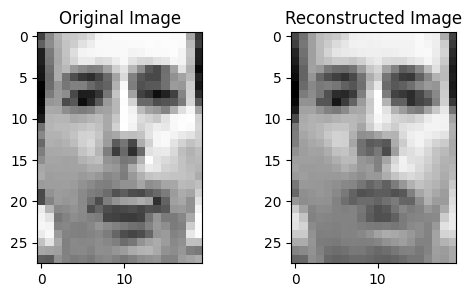

In [23]:
# Plotting the results
with torch.no_grad():
    model.eval()
    original_image = train_data[0].unsqueeze(0)
    reconstructed_image, _ = model(original_image)
    reconstructed_image = reconstructed_image.view(28, 20)

    # Reshape images for plotting
    original_image = original_image.cpu().view(28, 20).numpy()
    reconstructed_image = reconstructed_image.cpu().view(28, 20).numpy()

# Plotting original and reconstructed images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.show()

In [24]:
# obtain the latent representation and reconstruction for all the images
model.eval()
with torch.no_grad():
    latent_representations = []

    for data in train_loader:
        inputs = data[0].to(device)
        _, latent = model(inputs)
        latent_representations.append(latent.cpu().numpy())

latent_representations = np.concatenate(latent_representations, axis=0)

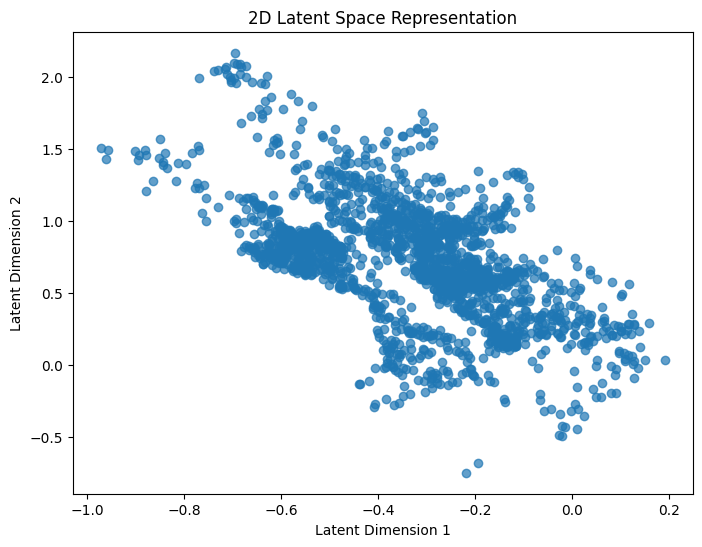

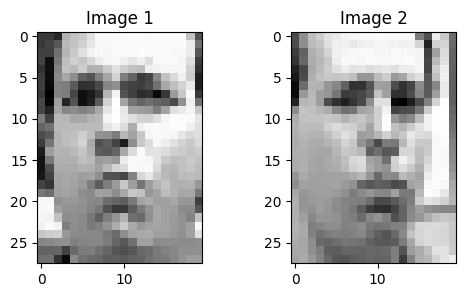

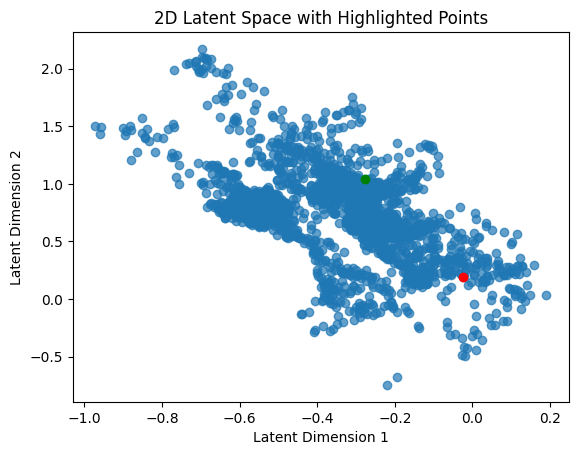

In [26]:
# Plotting the latent representation as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.7)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Representation')

point1_idx = np.random.randint(len(train_data))
point2_idx = np.random.randint(len(train_data))

# Plot images corresponding to these points
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

image1 = train_data[point1_idx].cpu().view(28, 20).numpy()
axes[0].imshow(image1, cmap='gray')
axes[0].set_title('Image 1')

image2 = train_data[point2_idx].cpu().view(28, 20).numpy()
axes[1].imshow(image2, cmap='gray')
axes[1].set_title('Image 2')

plt.show()

plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.7)
plt.scatter(latent_representations[point1_idx, 0], latent_representations[point1_idx, 1], color='red')  # Point 1
plt.scatter(latent_representations[point2_idx, 0], latent_representations[point2_idx, 1], color='green')  # Point 2
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space with Highlighted Points')
plt.show()



# Interpolation
1. Choose two points in the dataset (ideally the two image should look different) and highlight the corrsponding 
latent points in the scatter plot. 

2. Choosing them as a start and end point dwar a line between the two points in the latent
respresentations 
3. Finally estiamte the images corresponding to these representations using the decoder.

In [34]:
# Plotting the latent representation as a scatter plot
# You can choose to chage the start and end index to see the latent representation of different images
img_index_start = 0 
img_index_end = 1000

# Generate the points in the latent space
latent_point1 = latent_representations[img_index_start]
latent_point2 = latent_representations[img_index_end]

# Number of interpolation steps
n_interpolations = 15

# Interpolate in latent space
interpolated_points = np.linspace(latent_point1, latent_point2, n_interpolations)
interpolated_images = []

with torch.no_grad():
    for point in interpolated_points:
        latent_tensor = torch.from_numpy(point).float().to(device).unsqueeze(0)
        decoded_image = model.decoder(latent_tensor)
        decoded_image = decoded_image.view(28, 20).cpu().numpy()
        interpolated_images.append(decoded_image)


## Image Recovery

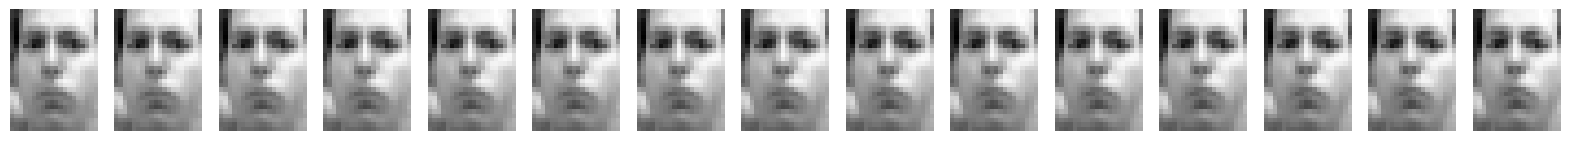

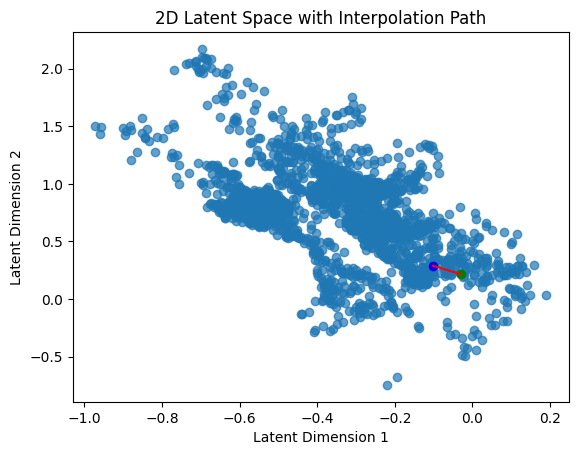

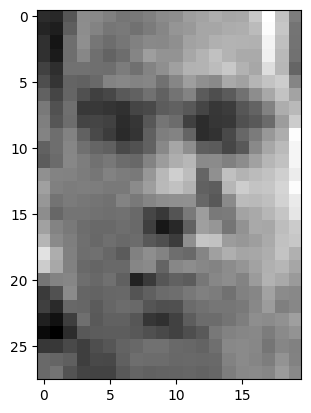

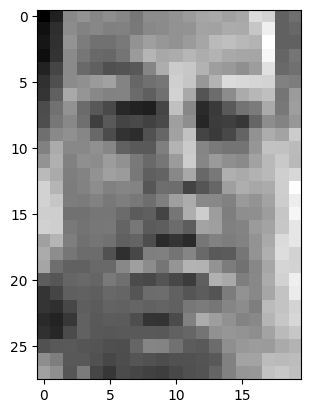

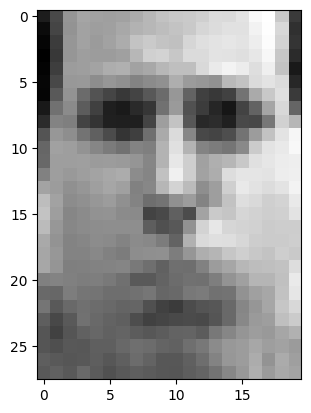

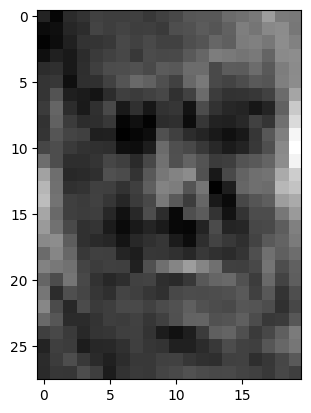

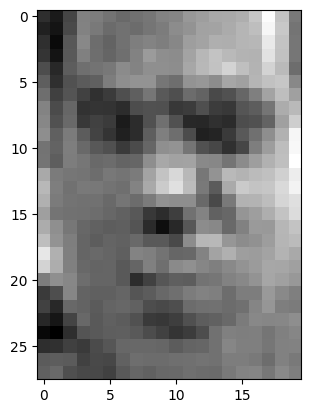

In [36]:

# Plotting the start and end images and the reconstructed images
fig, axes = plt.subplots(1, n_interpolations, figsize=(20, 2))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.show()

plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.7)
plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], color='red')  # Line segment
plt.scatter(latent_representations[point1_idx, 0], latent_representations[point1_idx, 1], color='green')  # Point 1
plt.scatter(latent_representations[point2_idx, 0], latent_representations[point2_idx, 1], color='blue')  # Point 2
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space with Interpolation Path')
plt.show()

# Manual test of the decoder
test_latent_vectors = [np.random.randn(2) for _ in range(5)]  # Generate some random latent vectors

with torch.no_grad():
    for vec in test_latent_vectors:
        latent_tensor = torch.from_numpy(vec).float().to(device).unsqueeze(0)
        decoded_image = model.decoder(latent_tensor)
        decoded_image = decoded_image.view(28, 20).cpu().numpy()
        plt.imshow(decoded_image, cmap='gray')
        plt.show()


# PCA based Interpolation

1. Obtain the latent codes using pca decompostion. 
2. Perform interpolation as done previously. 
3. Plot the results

In [41]:
from sklearn.decomposition import PCA

# Estimate the principal components of the data and the corresponding latent representation

faces_flat = faces.reshape(faces.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
faces_pca = pca.fit_transform(faces_flat)


In [42]:
# Compute the interpolation points 
point1_idx, point2_idx = 0, 1000  # Indices of the points to interpolate between

# Get their PCA representations
point1_pca = faces_pca[point1_idx]
point2_pca = faces_pca[point2_idx]

# Number of interpolation steps
n_interpolations = 10

# Interpolate in latent space
interpolated_pca = np.linspace(point1_pca, point2_pca, n_interpolations)


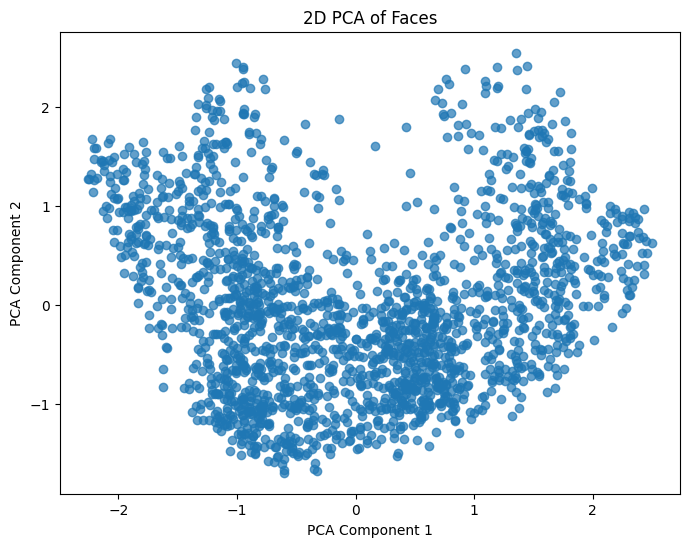

In [43]:
# Plotting the latent representation as a scatter plot

plt.figure(figsize=(8, 6))
plt.scatter(faces_pca[:, 0], faces_pca[:, 1], alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA of Faces')
plt.show()




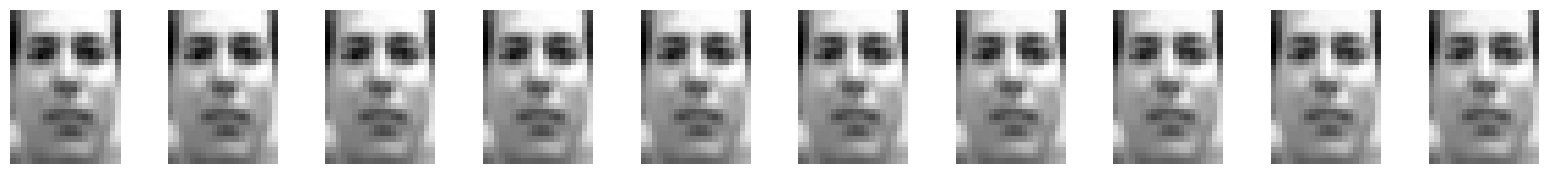

In [44]:
# Recover the images from the latent representation for the PCA 
fig, axes = plt.subplots(1, n_interpolations, figsize=(20, 2))

for i, point in enumerate(interpolated_pca):
    # Inverse PCA transform to get the original image space
    reconstructed_img = pca.inverse_transform(point).reshape(28, 20)
    axes[i].imshow(reconstructed_img, cmap='gray')
    axes[i].axis('off')

plt.show()

